In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
from glob import glob as glob
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
gsname = 'gs1120'

### load data

In [3]:
## run make_df-1102.py to make dfs
datadf = datadf1 = pd.read_csv('data/%s-datadf-1.csv'%gsname)
datadf = datadf2 = pd.read_csv('data/%s-datadf-0.csv'%gsname)


In [4]:
gsdf = pd.read_csv('data/%s-summdf.csv'%gsname).astype(float)
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,testacc-b,acc2-b,testacc-e,acc2-e,testacc-i,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m
0,0.0,0.383941,48.999616,65.967600,0.384398,0.0,1.0,0.661294,1.0,1.0,0.500669,0.228744,0.499844,0.235420,0.498534,0.496188,0.500576,0.490672,0.501027,0.739982
1,0.0,0.629862,44.212603,69.603395,1.084579,0.0,1.0,0.820771,1.0,0.0,0.502198,0.237356,0.497543,0.237329,0.500095,0.494240,0.499848,0.489597,0.498645,0.734096
2,0.0,0.823395,4.394111,25.069255,0.498482,0.0,1.0,0.439935,1.0,0.0,0.497427,0.231709,0.498587,0.230717,0.500107,0.492433,0.500052,0.490509,0.500489,0.740307
3,0.0,0.936755,17.321534,47.692184,0.515758,0.0,1.0,0.514161,1.0,0.0,0.500136,0.234812,0.499187,0.232234,0.497484,0.492145,0.498306,0.490845,0.500669,0.740484
4,0.0,0.969041,1.236475,59.943728,0.785351,0.0,1.0,0.739099,1.0,1.0,0.500219,0.233782,0.501270,0.237083,0.498990,0.489998,0.500835,0.492163,0.500160,0.736315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625376,0.0,97.752380,80.764531,45.435254,0.496273,0.0,1.0,0.279220,1.0,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
625377,0.0,98.426458,24.669835,78.742065,0.920982,0.0,1.0,0.366653,1.0,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
625378,0.0,98.701723,15.768842,82.038218,0.022219,0.0,1.0,0.184680,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
625379,0.0,98.798920,1.777703,32.098360,0.750849,0.0,1.0,0.765695,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


In [5]:
## human data
hdf = pd.read_csv('../human_data.csv')
humanD = {}
for c in ['blocked','interleaved','early','middle','late']:
  humanD[c[0]] = hdf.loc[:,('%s mean')%c].values.T[-40:].mean()
## difference to human
for c in ['b','i','e','m','l']:
  gsdf['%s-test_diff'%c] = np.abs(gsdf.loc[:,'testacc-%s'%c] - humanD[c])

In [6]:
# datadf.columns
# paramL = ['concentration', 'stickiness_wi', 'stickiness_bt',
#        'sparsity', 'pvar', 'lrate', 'lratep', 'decay_rate']

### compute df metrics, form summary df

In [7]:
# subset of dataframe containing relevant params
Btest = gsdf.loc[:,'testacc-b'] > 0.95
Itest1 = gsdf.loc[:,'testacc-i'] > 0.6
Itest2 = gsdf.loc[:,'testacc-i'] < 0.65
Etest = gsdf.loc[:,'testacc-e'] > 0.8
Mtest1 = gsdf.loc[:,'testacc-m'] > 0.8
Mtest2 = gsdf.loc[:,'testacc-m'] < 0.85
Ltest = gsdf.loc[:,'testacc-l'] > 0.6
Iblock2 = gsdf.loc[:,'acc2-i'] > 0.51
skipt1 = gsdf.loc[:,'skipt1'] == 0
MItest = gsdf.loc[:,'testacc-m'] - gsdf.loc[:,'testacc-i'] > 0.1
LItest = gsdf.loc[:,'testacc-l'] - gsdf.loc[:,'testacc-i'] > 0.1

C = Btest&Itest1&Itest2&skipt1
sgsdf = gsdf[C]
sgsdf = sgsdf.sort_values('testacc-l',ascending=False)
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
500518,0.0,4.751815,55.500084,21.350040,0.080803,0.0,1.0,0.026217,1.0,0.0,...,0.5,0.981503,0.5,0.974938,0.945077,0.068333,0.007168,0.064024,0.284600,0.238729
134921,0.0,3.445600,34.624973,3.200529,0.115386,0.0,1.0,0.016537,1.0,0.0,...,0.5,0.981295,0.5,0.981525,0.948837,0.068217,0.001267,0.066665,0.291187,0.238521
181374,0.0,3.046303,72.888896,10.630935,0.129630,0.0,1.0,0.035649,1.0,0.0,...,0.5,0.981235,0.5,0.981471,0.954360,0.068184,0.003971,0.073461,0.291134,0.238460
121145,0.0,7.395794,72.403458,24.936717,0.126220,0.0,1.0,0.092269,1.0,0.0,...,0.5,0.981180,0.5,0.974655,0.946721,0.059749,0.007370,0.060577,0.284318,0.238406
481983,0.0,7.131445,66.529255,29.486264,0.155904,0.0,1.0,0.054335,1.0,0.0,...,0.5,0.981052,0.5,0.981349,0.948090,0.068094,0.002413,0.073374,0.291012,0.238277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226482,0.0,26.262607,90.032347,45.445472,0.548754,0.0,1.0,0.090221,1.0,0.0,...,0.5,0.875580,0.5,0.908289,0.935513,0.041493,0.024939,0.047727,0.217951,0.132806
3039,0.0,25.188158,93.457920,43.689749,0.198446,0.0,1.0,0.091365,1.0,0.0,...,0.5,0.873001,0.5,0.914042,0.941501,0.052256,0.008981,0.043528,0.223705,0.130226
429623,0.0,27.361149,89.789593,18.778557,0.330234,0.0,1.0,0.102364,1.0,0.0,...,0.5,0.870969,0.5,0.888578,0.910202,0.049347,0.016105,0.015535,0.198241,0.128195
282421,0.0,28.065356,73.954458,42.967020,0.726300,0.0,1.0,0.096903,1.0,0.0,...,0.5,0.868104,0.5,0.836396,0.927639,0.040478,0.029567,0.035139,0.146058,0.125330


In [22]:
## subset of df by difference from human
# Bd = gsdf.loc[:,'b-test_diff'] < 0.1
Btest = gsdf.loc[:,'testacc-b'] > 0.85
Id = gsdf.loc[:,'i-test_diff'] < 0.1
Ed = gsdf.loc[:,'e-test_diff'] < 0.05
Md = gsdf.loc[:,'m-test_diff'] < 0.05
Ld = gsdf.loc[:,'l-test_diff'] < 0.05

C = Btest&Id&Ed&Md&Ld
sgsdf = gsdf[C]
sgsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,skipt1,...,acc2-i,testacc-l,acc2-l,testacc-m,acc2-m,b-test_diff,i-test_diff,e-test_diff,m-test_diff,l-test_diff
413829,0.0,1.785814,44.699381,92.514726,0.023318,0.0,1.0,0.098623,1.0,0.0,...,0.504784,0.698681,0.520879,0.647545,0.816864,0.056296,0.050645,0.041146,0.042792,0.044093
445290,0.0,1.890317,41.346061,76.917031,0.024007,0.0,1.0,0.102473,1.0,0.0,...,0.513236,0.698447,0.534907,0.649918,0.823118,0.043766,0.051086,0.045840,0.040419,0.044327


### plt single condition

In [23]:
def get_cond_df(row):
  ## form query string for above row
  query_str = " and ".join(
    ["%s == %f"%(k,v) for k,v in dict(row.astype(float)[1:10].round(4)).items()]
  )
  print('query',query_str)
  ## df of single parameter condition`
  cond_df = datadf1.round(4).query(query_str)
  if not len(cond_df):
    cond_df = datadf2.round(4).query(query_str)
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  print('found',paramstr)
  return cond_df


In [15]:
def plt_cond_df(cond_df):
  f,axar = plt.subplots(1,1,figsize=(20,8))
  ax=axar
  paramstr = "__".join(["%s-%s"%(k,v) for k,v in cond_df.iloc[0][1:12].items()])
  for c,cdf in cond_df.groupby('cond'):
    try:
#       if c not in ['blocked','interleaved']:
#         print('FIGURES WITH BI ONLY')
#         continue
      ax.plot(np.arange(200),cdf.acc,label=c)
    except:
      print('err',paramstr,c)
      continue
  ax.set_ylim(0,1)
  plt.legend()
  plt.axhline(0.5,c='k',ls='--')
  
  plt.title("%s\n%s"%(paramstr[:94],paramstr[94:]))
  plt.savefig('figures/analysis_gs/acc-%s.png'%paramstr)


In [16]:
## select single param for plotting full acc trace
row = sgsdf.sort_values('testacc-l',ascending=False).iloc[0]
print(row.astype(float))
cond_df = get_cond_df(row)

Unnamed: 0        0.000000
concentration     2.684126
stickiness_wi     1.870269
stickiness_bt    61.870331
sparsity          0.004613
pvar              0.000000
lrate             1.000000
lratep            0.549786
decay_rate        1.000000
skipt1            1.000000
testacc-b         0.981999
acc2-b            0.951773
testacc-e         0.981999
acc2-e            0.951773
testacc-i         0.697737
acc2-i            0.683625
testacc-l         0.708223
acc2-l            0.691097
testacc-m         0.660867
acc2-m            0.590622
b-test_diff       0.068590
i-test_diff       0.048549
e-test_diff       0.073867
m-test_diff       0.029471
l-test_diff       0.034551
Name: 220334, dtype: float64
query concentration == 2.684100 and stickiness_wi == 1.870300 and stickiness_bt == 61.870300 and sparsity == 0.004600 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.549800 and decay_rate == 1.000000 and skipt1 == 1.000000
found concentration-2.6841__stickiness_wi-1.8703__stickiness_b

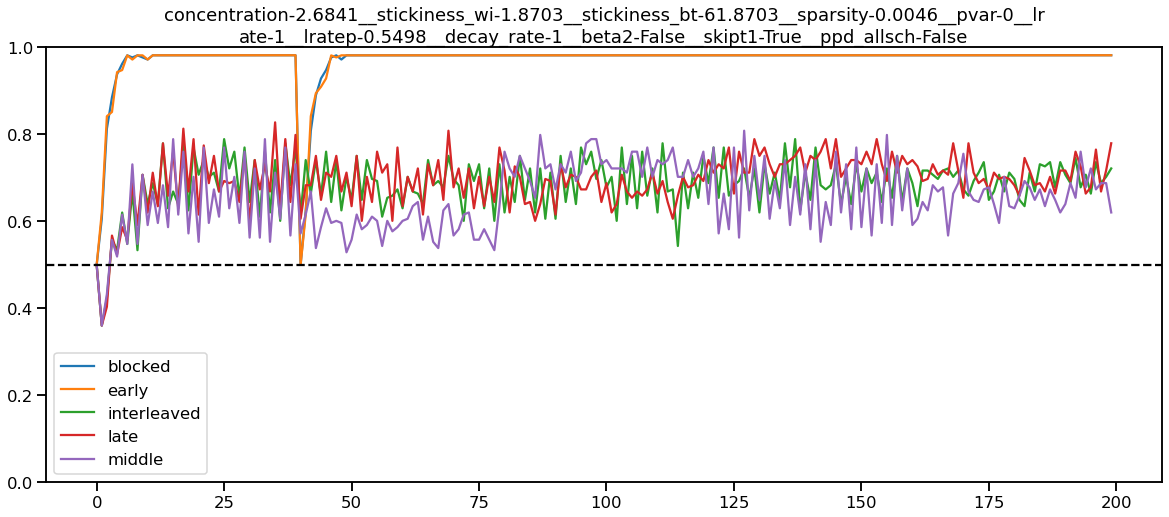

In [17]:
plt_cond_df(cond_df)

### plot full subtable

In [24]:
for idx,row in sgsdf.iterrows():
  print()
  cond_df = get_cond_df(row)
  plt_cond_df(cond_df)
  plt.close('all')


query concentration == 1.785800 and stickiness_wi == 44.699400 and stickiness_bt == 92.514700 and sparsity == 0.023300 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.098600 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-1.7858__stickiness_wi-44.6994__stickiness_bt-92.5147__sparsity-0.0233__pvar-0__lrate-1__lratep-0.0986__decay_rate-1__beta2-False__skipt1-False__ppd_allsch-False

query concentration == 1.890300 and stickiness_wi == 41.346100 and stickiness_bt == 76.917000 and sparsity == 0.024000 and pvar == 0.000000 and lrate == 1.000000 and lratep == 0.102500 and decay_rate == 1.000000 and skipt1 == 0.000000
found concentration-1.8903__stickiness_wi-41.3461__stickiness_bt-76.917__sparsity-0.024__pvar-0__lrate-1__lratep-0.1025__decay_rate-1__beta2-False__skipt1-False__ppd_allsch-False


In [14]:
np.arange(200)[40:80]

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79])